In [1]:
import os
import numpy as np
import pandas as pd

os.chdir('../core')

In [2]:
DATA_DIR = "../data"
FILE_NAME = "train.csv"

df = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME))
df = df.drop(columns=["Employee ID"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df["Attrition"] = df["Attrition"].map({"Stayed": 1, "Left": 0})
print(df.shape)

df.head(5)

(59598, 23)


,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,29,Female,10,Education,4262,Fair,Medium,High,0,Yes,...,0,Senior,Small,52,No,No,No,Poor,High,1
1,18,Male,3,Finance,9032,Good,Very High,High,3,Yes,...,3,Entry,Medium,50,No,No,No,Good,Medium,0
2,30,Female,9,Healthcare,8610,Poor,Medium,Average,2,No,...,4,Entry,Large,62,No,No,No,Fair,Low,0
3,46,Male,2,Education,5071,Fair,High,Average,1,Yes,...,0,Entry,Small,39,No,No,No,Good,High,0
4,37,Male,17,Technology,10037,Fair,High,Average,0,No,...,1,Mid,Medium,42,No,No,No,Good,Low,0


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from processor import LabelEncoderTransformer


target_column = "Attrition"

# Choose numeric columns except the target column
numeric_columns = df.drop(columns=[target_column]).select_dtypes(include=['int64', 'float64']).columns.tolist()
category_columns = df.select_dtypes(include=['object']).columns.tolist()

processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', LabelEncoderTransformer(), category_columns)
    ]
)

X = processor.fit_transform(df.drop(columns=[target_column]), df[target_column])
y = df[target_column].values.reshape(-1, 1)

X

array([[-0.79190512, -0.51164494, -1.4131925 , ...,  0.        ,
         3.        ,  0.        ],
       [-1.70253344, -1.13409473,  0.80392784, ...,  0.        ,
         2.        ,  2.        ],
       [-0.70912073, -0.60056634,  0.60778009, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.0359388 , -1.22301613, -1.15662008, ...,  0.        ,
         2.        ,  1.        ],
       [-0.87468951,  0.02188346,  1.39515994, ...,  0.        ,
         2.        ,  2.        ],
       [-0.21241438,  0.64433325, -1.38019134, ...,  0.        ,
         2.        ,  2.        ]])

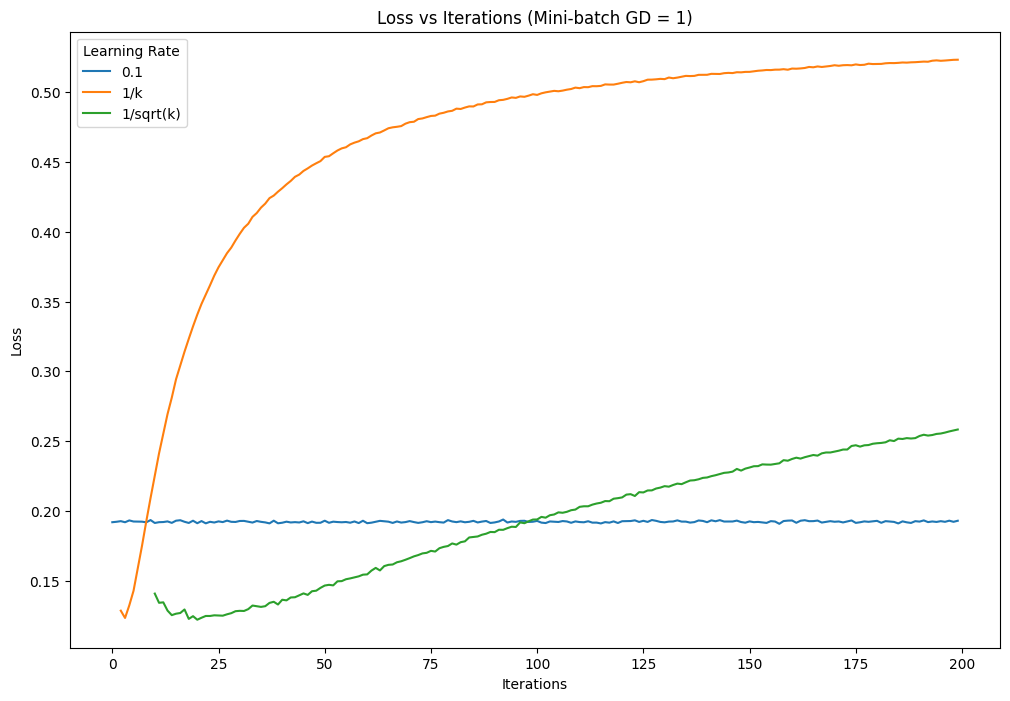

In [16]:
import matplotlib.pyplot as plt

from base import BaseLR
from loader import DataLoader
from time import time

class LogisticRegressionBatchGD(BaseLR):
    def __init__(
        self, 
        learning_rate=0.01, 
        num_iterations=100,
        regularization="l2",
        lambda_=1.0,
        batch_size=32,
        fit_intercept=True, 
        log=True,
        dynamic_learning_rate="1/k" # Only support [1/k, 1/sqrt(k)]
    ):
        super().__init__(learning_rate, num_iterations, regularization, lambda_, fit_intercept, log)
        self.batch_size = batch_size
        self.dynamic_learning_rate = dynamic_learning_rate


    def __get_dynamic_learning_rate(self, k, type_):
        if type_ == "1/k":
            return 1 / (k + 1)
        elif type_ == "1/sqrt(k)":
            return 1 / np.sqrt(k + 1)
        else:
            return self.learning_rate

    def fit(self, X, y):
        if self.fit_intercept:
            X = super()._BaseLR__add_intercept(X)
        
        self.step_history = []
        self.theta = np.zeros((X.shape[1], 1))
        
        start = time()
        for k in range(1, self.num_iterations + 1):
            total_loss = 0
            data_loader = DataLoader(X, y, batch_size=self.batch_size)
            for batch_X, batch_y in data_loader:
                z = np.dot(batch_X, self.theta)
                h = super()._BaseLR__sigmoid(z)

                gradient = self.gradient(h, batch_y, batch_X, self.theta)
                self.theta -= self.__get_dynamic_learning_rate(k, self.dynamic_learning_rate) * gradient

                z = np.dot(batch_X, self.theta)
                h = super()._BaseLR__sigmoid(z)
                loss = super()._BaseLR__loss(h, batch_y, self.theta)
                total_loss += loss
                self.step_history.append(loss)
            
            if self.log == True:
                self.history.append(total_loss / len(data_loader))
                self.times.append(time() - start)

learning_rates = [0.1, "1/k", "1/sqrt(k)"]
num_iterations = 200
batch_size = 1

loggers = {}
for learning_rate in learning_rates:
    model = LogisticRegressionBatchGD(
        learning_rate=0.1,
        num_iterations=num_iterations, 
        regularization="None",
        batch_size=batch_size, 
        dynamic_learning_rate=learning_rate
    )
    model.fit(X, y)
    loggers[learning_rate] = model.history


# Plot loss
plt.figure(figsize=(12, 8))
for learning_rate in learning_rates:
    plt.plot(range(len(loggers[learning_rate])), loggers[learning_rate], label=f"{learning_rate}")

plt.title(f"Loss vs Iterations (Mini-batch GD = {batch_size})")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(title="Learning Rate")
plt.show()